# `time_delay` y `dimension` óptimos para el encaje.

En este notebook nos centraremos en entender cómo calcular los parámetros óptimo para el encaje de Takens de una serie de tiempo.

Utilizamos la paquetería de `giotto-tda` con el comando `single_takens_embedding` con la opción de parametros `search` para encontrar los parámetros óptimos.

Dado que ahora mi dimensión puede ser mayor a 3, utilizaremos PCA para visualizar los resultados.

Observaremos el parámetro `time_delay` con la paquetería `natlisa` quien nos proporciona un gráfica del "mutual information" entre la serie de tiempo y su retraso para un rango de retrasos.

Para installar `natlisa`: ejecuta 

> !pip install git+https://github.com/manu-mannattil/nolitsa.git



In [14]:
import numpy as np
import pandas as pd
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud
import plotly.graph_objects as go
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

## Datos periódicos:

Sigamos trabajando con la serie de tiempo dada por la función $f(t)=\cos(5t).$

Construyamos nuestra serie de tiempo:

```python
x_periodic=np.linspace(0,10,1000)
y_periodic=np.cos(5*x_periodic)
```

In [5]:
x_periodic=np.linspace(0,10,1000)
y_periodic=np.cos(5*x_periodic)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_periodic, y=y_periodic, mode='markers', name='periodic signal'))
fig.show()

### 1. Optimal time delay

El optimal time delay usa información euristica para encontrar el mejor retraso. El cálculo del `mutual information` se refiere a una medida de dependencia entre dos observaciones. Podemos considerar que si estas observaciones son vectores en $\mathbb{R}^2$ si mis observaciones no estan correlacionadas entonces vemos un par de vectores l.i ortogonales, pero si mis vectores no son del todo ortogonales (pero si l.i.) entonces comparten cierta información (la proyección de un vector sobre el otro).

Cuando desdoblamos una serie de tiempo queremos conservar la mayor información posible, por lo que queremos que nuestros vectores sean lo más ortogonales posibles. 

Si comparamos la variación del `mutual_information` conforme cambiamos el parametro $\tau$ (`time_delay`) podemos ver que el valor de `mutual_information` es mayor cuando $\tau=0$ y va disminuyendo conforme aumentamos el valor de $\tau$. Más aún, los valores de $\tau$ para los cuales el `mutual_information` es un mínimo local son aquellos buenos candidatos para nuestro encaje. 

#### ¿Cómo se diferencia entre valores con mínimo local?

Si seguimos en la visión de vectores, el cambio de un valor $\tau$ donde ocurra un mínimo local lo que hacemos es una rotación (doblez en mi encaje).

Ahora calculemos los parámetros óptimos para el encaje de Takens:

Para ello usamos la función `takens_embedding_optimal_parameters` de la paquetería `giotto-tda`, el cual utiliza el mutual information algorithm para el time_delay.

Proporcionamos una tope máximo de valores a los cuales nos gustaría que el algoritmo busque los parámetros óptimos.


```python
max_periodic_dimension=30
max_periodic_time_delay=30
stride=1
tau,d=takens_embedding_optimal_parameters(y_periodic, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'Optimal dimension: ', d)
 ```	

In [9]:
max_periodic_dimension=30
max_periodic_time_delay=30
stride=1
tau,d= takens_embedding_optimal_parameters(y_periodic, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  29 
Optimal dimension:  18


El algoritmo de `giotto-tda` nos da como resultado que el parámetro óptimo para el `time_delay` es 29 y la dimensión óptima es 18, cuando el stride es 1.

Si modificamos el stride, estos parámetros cambiarán.

Veamos cómo se ve el encaje de Takens con estos parámetros:

```python
embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)
```

In [12]:
embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=2,
     time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (507, 18)


Vamos a comparar el parámetro `time_delay` de `giotto-tda` con el parámetro `time_delay` que nos da la paquetería `natliso`:

La función `delay.dmi` nos crea un array con la información mutua entre los valores de nuestro vector y sus retrasos, y como varía esta información conforme al retraso aumenta. Notemos que asumimos que `maxtau=30` dado que fue el máximo que le dimos a `giotto-tda` para que buscara el parámetro óptimo.

```python	
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y_periodic, maxtau=30))
```

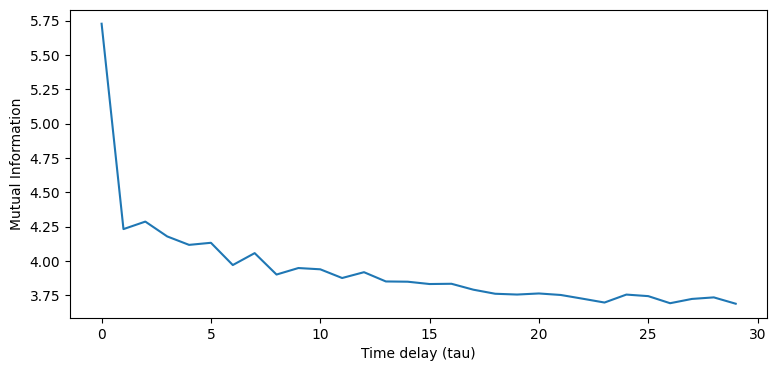

In [15]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y_periodic, maxtau=30))

En la gráfica podemos observar que el primer mínimo local se encuentra cerca del 1 (aprox.), nada comparado con el 29 que nos da `giotto-tda`. Esto es por que el parámetro escogido por `giotto-tda` es el mínimo global en esta función.

In [16]:
def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

find_optimal_delay(y_periodic, maxtau=30)

1

Veamos como se ve este encaje, cuando cambiamos el parámetro `time_delay` a 1 y dejaremos el parámetro `dimension` en 18.

```python
embedding_dimension_periodic = 18
embedding_time_delay_periodic = 1
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)
```


In [17]:
embedding_dimension_periodic = 18
embedding_time_delay_periodic = 1
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (983, 18)


__Ejercicio Moral:__ Compara los diagramas de persistencia de ambos encajes y convéncete que estas elecciones de parámetros son (hasta cierto punto equivalentes).

## 2. Optimal embedding dimension

Con el parámetro `time_delay` que encontramos en la sección previa fijo, ahora vamos a encontrar el parámetro `dimension` que nos de el mejor encaje.

Para calcular el paramétro de `dimension` optimo utilizamos algo que se conoce como `false nearest neighbors`. El `false nearest neighbors` es una probabilidad (entre 0 y 1) que nos mide cuantos porcentaje de vecinos cercanos en la serie de tiempo, continuan siendo vecinos cercanos en el encaje de Takens.

Usualmente, fijado nuestro valor para el `time_delay`, escogemos el valor de `dimension` que nos de el menor porcentaje de `false nearest neighbors`, usualmente aquel que sucede luego del 0.1.

En la búsqueda (con `giotto-tda`) para el la serie de tiempo del coseno, nos proporciona que el parámetro `dimension` óptimo es 18.


In [18]:
max_periodic_dimension=30
max_periodic_time_delay=30
stride=1
tau,d= takens_embedding_optimal_parameters(y_periodic, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  29 
Optimal dimension:  18


Realicemos el plot de la razón `false_neighbors` para estos datos con el retraso fijo en 29 (y luego en 1). Para esto utilizaremos la función de `natliso` `dimension.fnn`.

Para esto, pedimos que nos realice la razón para las dimensiones del 1 al 20. Para esto, el algoritmo `dimension.fnn` utiliza tres test y regresa los arrays para cada test. El test 1, es aquel que nos regresa el valor que describimos al principio.

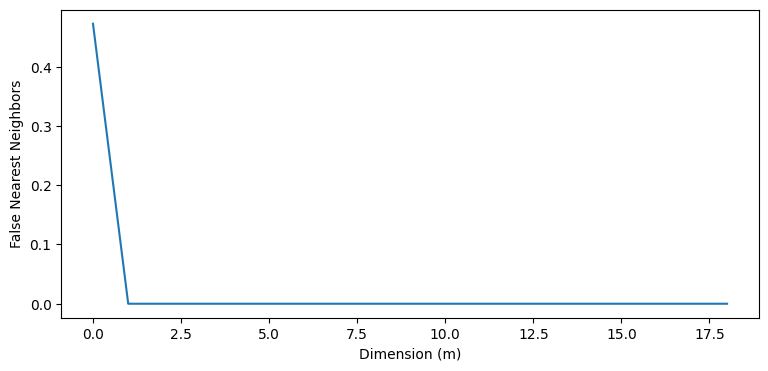

In [23]:
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(y_periodic, tau=29, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=29)')
plt.plot(f1)

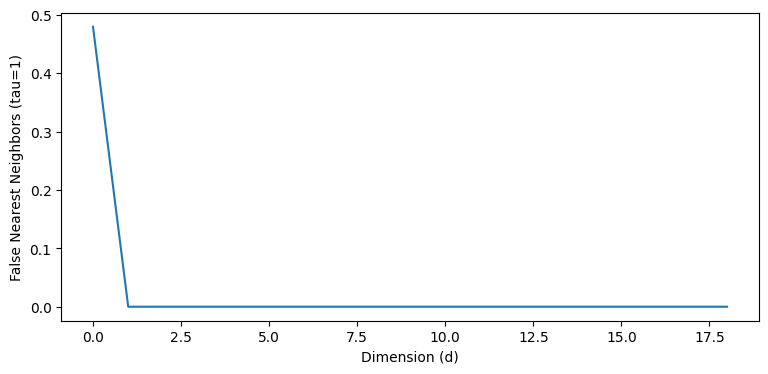

In [26]:
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(y_periodic, tau=1, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)

En las dos gráficas observamos un comportamiento similar, donde el valor de `false_neighbors` es mínimo en la dimensión 2 y se mantiene estable. 

Esto sucede dado que nuestra serie de tiempo es periódica, y sabemos que proviene de un sistema dinámico que es un ciclo. 

Por lo que en esta serie de tiempo particular, los valores que proporciona `giotto-tda` no son los más adecuados dado que incrementa la dimensión y el retraso más de lo necesario.

## 2. Serie de tiempo caótica (no periódica)

Ahora vamos a realizar el mismo análisis para una serie de tiempo caótica, en este caso utilizaremos la serie de tiempo de `lorenz` que viene en la paquetería `openml`.

Necesitaremos la paquetería get_datasets de openml para obtener la serie de tiempo de lorenz.

```python
from openml.datasets.functions import get_dataset
```


In [27]:
from openml.datasets.functions import get_dataset
lorenz = get_dataset(42182).get_data(dataset_format='array')[0][0:, 0]
t = [i for i in range(len(lorenz))]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t, y=lorenz, mode='markers'))
fig.show()

In [30]:
max_periodic_dimension=60
max_periodic_time_delay=60
stride=1
tau,d= takens_embedding_optimal_parameters(lorenz, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  60 
Optimal dimension:  40


Notemos que el algoritmo propio de `giotto-tda` nos dice que el parámetro `time_delay` óptimo es 60 y el parámetro `dimension` óptimo es 40.

Que si pensamos en como formamos nuestro encaje, no debería haber mas de un punto. Lo cual no nos ayuda.

Vamos a realizar las gráficas de `false_neighbors` y para `mutual_information`. para esta serie de tiempo para determinar valores heuristicos.

Comenzaremos con `mutual_information`:

El primer mínimo local ocurre en:


26

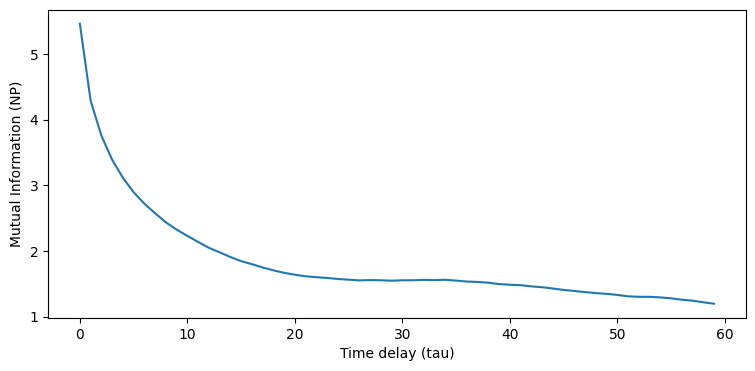

In [32]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information (NP)')
plt.plot(delay.dmi(lorenz, maxtau=60))
print('El primer mínimo local ocurre en:')
find_optimal_delay(lorenz, maxtau=60)


Una vez decidido nuestro valor para `time_delay`, podemos utilizar la función `dimension.fnn` para obtener la dimensión óptima para nuestro encaje.


La dimensión óptima con tau=26 es:  3


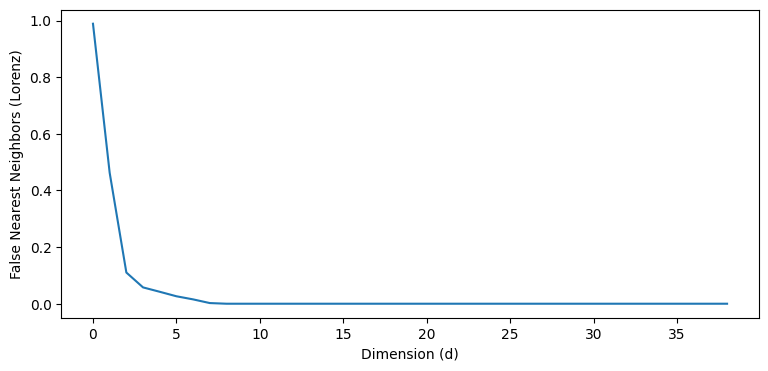

In [40]:
dim = np.arange(1, 40)
f1, f2, f3 = dimension.fnn(lorenz, tau=26, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=26 es: ", [f<=0.1 for f in f1].index(True))

Como teoría, el attractor de Lorenz es un sistema dinámico cuyas órbitas viven en $\mathbb{R}^3,$ por lo que el método heurístico coincide con el teórico.

__Ejercicio Moral:__ Realiza el encaje de Takens con los parámetros obtenidos mediante giotto-tda, utiliza PCA con n=3, y gráfica el resultado. ¿Qué observas?